In [35]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import pandas as pd
import datetime as dt
%matplotlib inline
import sys
import os
sys.path.append(os.path.abspath('../Backend'))
import wahlrecht_polling_firms
import copy
from scipy.stats.mstats import mquantiles
from  scipy.optimize import curve_fit as fit
import numpy.random as r

def multidiri(data,itrs,pseudonobs):
    length = len(data)
    m = lambda *arg: np.zeros((itrs,length))
    
    #parties
    cdu = m(); spd = m(); fdp = m()
    b90 = m(); afd = m(); lin = m()
    oth = m()
    
    i = 0;
    #gammadist
    g = lambda a,b:r.gamma(a,b)
    #random number of supporters
    h = lambda l,u:r.randint(l,u);
    
    #average
    avg=np.zeros(7)
    while i < itrs:
        
        prior = np.zeros(7)
        #+-100 for each population, should be more sensible
        prior = np.array([h(data[0][j]-100,data[0][j]+100) for j in range(7)])
        
        sample = np.zeros(7);
        s=np.zeros(7)
        
        for week in range(0,length):
        #    if week == 0:
        #        post = data[week] + prior
        #    else:
                post = data[week] + sample*pseudonobs
                sample  = np.array([g(post[j],1) for j in range(7)])
                
                sample = sample/np.sum(sample)
                cdu[i][week]=sample[0]
                spd[i][week]=sample[1]
                fdp[i][week]=sample[3]
                b90[i][week]=sample[2]
                afd[i][week]=sample[5]
                lin[i][week]=sample[4]
                oth[i][week]=sample[6]
                
                # random-walk
                s = sample + np.array([g(post[k],1) for k in range(7)])
                sample = s/(np.sum(s))
                if week==length-1:
                    avg += post
                    i += 1
                    print( '\r{0:3.2f}% completed'.format(i/itrs*100),end='')
    #print (avg/itrs) # print Dirich params
    return {'cdu':cdu,'spd':spd,'fdp':fdp,'b90':b90,'afd':afd,\
    'lin':lin,'oth':oth}

In [41]:
complete_data_dict = wahlrecht_polling_firms.get_tables()

fors = complete_data_dict['emnid']
org = copy.deepcopy(fors)
parties = ['CDU/CSU', 'SPD', 'GRÜNE', 'FDP', 'LINKE', 'AfD', 'Sonstige']#,'Nichtwähler/Unentschl.']
sum_ = fors[parties].sum(axis=1)
for party in parties:
    fors[party] *= np.round(fors['Befragte']*1000/sum_)

In [42]:
data = copy.deepcopy(fors[parties])#[:-1]])


In [43]:
def predict(data,last,future):
    popt, pcov = fit(quad,np.arange(0,len(data)),data*100)
    return quad(np.arange(future,len(data)),*popt)

quad = lambda x,a,b,c : a +x*b+ c*x**2

In [50]:
np.array(data)[0][0]
res= multidiri(np.array(data),1000,10000)

100.00% completed

cdu result= 39.02% +2.02%-2.11%
spd result= 24.97% +1.98%-1.79%
fdp result= 7.00% +1.10%-1.12%
b90 result= 7.01% +1.19%-1.04%
afd result= 8.01% +1.16%-1.08%
lin result= 9.01% +1.31%-1.23%
oth result= 4.98% +0.95%-0.93%


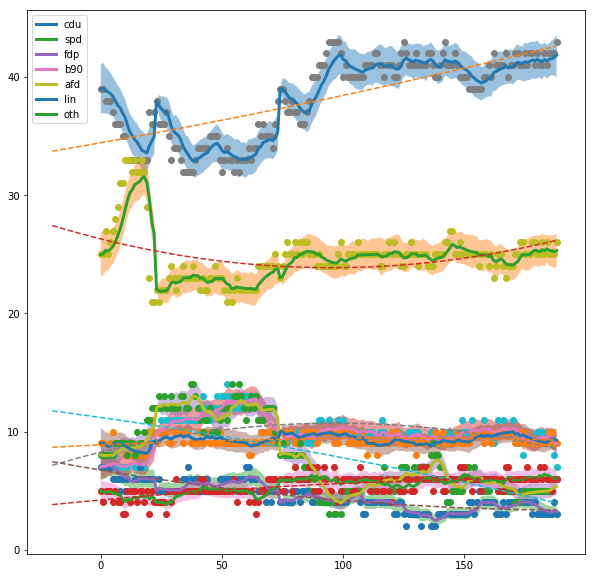

In [51]:
plt.figure(figsize=(10,10))
prediction ={}
for key in res:
    bounds = mquantiles(res[key],prob=[.025,.975],axis=0)
    #plt.ylim(30,40)
    #plt.xlim(0,25)
    means= res[key].mean(axis=0)
    plt.plot(means*100,lw=3,label=key)
    future=-20
    plt.plot(np.arange(future,len(means),1),predict(means,0,future),'--')
    
    prediction[key] =np.array([predict(trace,0,future)for trace in res[key]])
    plt.fill_between(np.arange(len(org)),y1=bounds[0]*100,y2=bounds[1]*100,alpha=.45)
    today = (res[key].mean(axis=0)*100)[0]
    print(key, 'result= {0:3.2f}% +{1:3.2f}%-{2:3.2f}%'.format(today,-today+bounds[1][0]*100,-bounds[0][0]*100+today))
plt.legend()
for party in parties:
    plt.scatter(np.arange(len(org)),org[party])

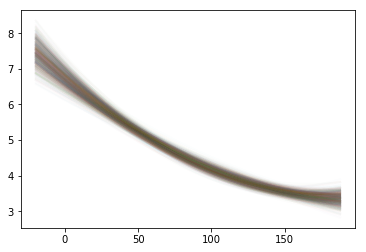

In [52]:
for pred in prediction['fdp']:
    plt.plot(np.arange(future,len(org)),pred,alpha=.01,lw=2)

cdu 37.7230742386 [ 33.68286311  37.52970204  42.4257052 ]
spd 24.9173596611 [ 23.65597636  24.5500634   27.89637744]
fdp 4.87708052075 [ 3.31330036  4.60624701  7.36863361]
b90 9.79780484436 [  7.18996574  10.12321454  10.87728778]
afd 8.21068375639 [  4.08767503   8.44732763  11.52304029]
lin 9.26257786723 [ 8.90192891  9.3170985   9.39606885]
oth 5.21141907717 [ 3.43719103  5.5197276   5.98331003]


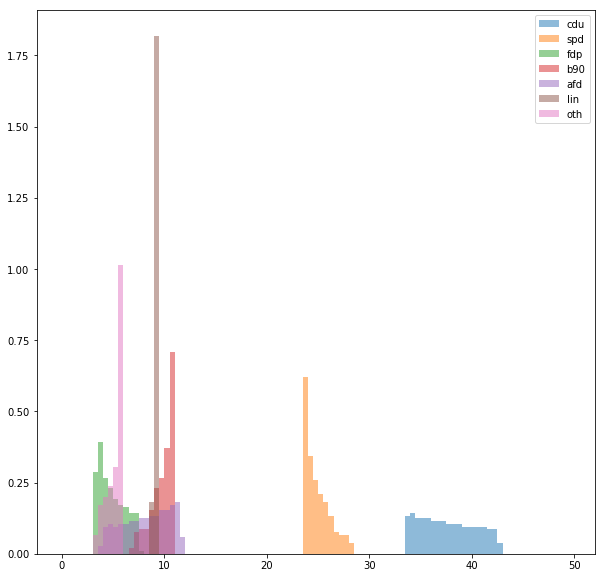

In [53]:
summ = 0
plt.figure(figsize=(10,10))
for key in prediction:
    count,bins, _ =plt.hist(prediction[key][0],bins=np.arange(0,50,.5),normed=True,label=key,alpha=.5)
    
    print(key, np.mean(prediction[key][0]), mquantiles(prediction[key][0],prob=[0.025,.5,0.975]))
    summ += np.mean(prediction[key][0])
plt.legend()
    #plt.show()
    #print(key)

In [54]:
print(summ)

99.9999999656


In [55]:
def predict(data,last,future):
    popt, pcov = fit(quad,np.arange(0,len(data)),data*100)
    return quad(np.arange(future,len(data)),*popt)

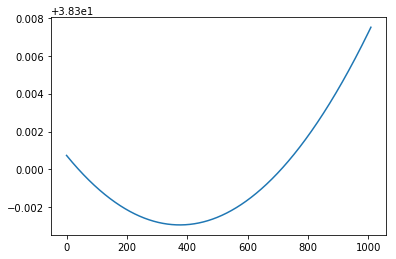

In [56]:
plt.plot(predict(np.mean(res['cdu'],axis=1),0,-10))

In [58]:
popt, pcov = fit(quad,np.arange(len(res['cdu'][0]))[:estq],(res['cdu'].mean(axis=0)*100)[:estq])

In [59]:
estq =188

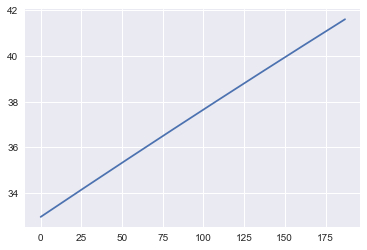

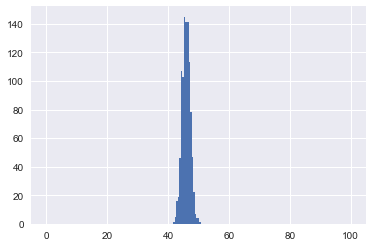

In [292]:
result, _,__ = plt.hist(res['cdu'].T[0]*100+res['fdp'].T[0]*100,bins=np.linspace(0,100,200));

In [293]:
(result[int(len(result)/2):].sum()/np.array(result).sum())*100

0.5

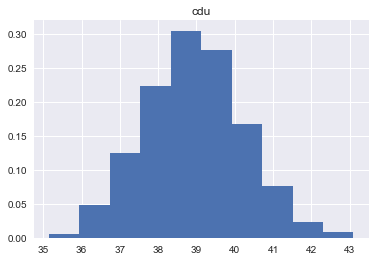

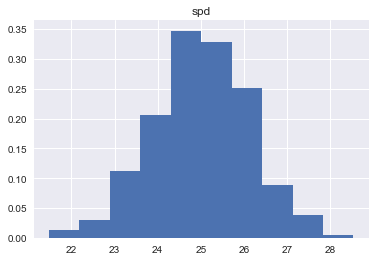

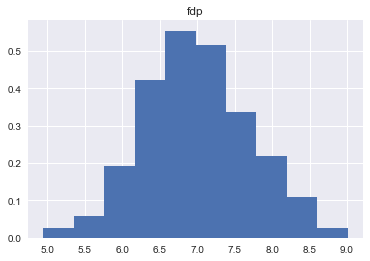

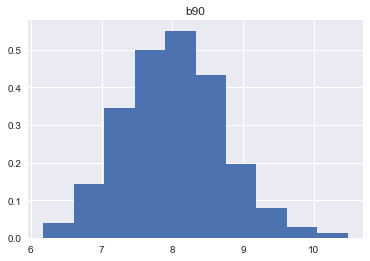

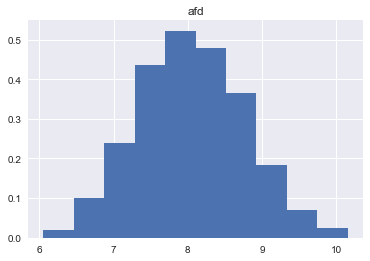

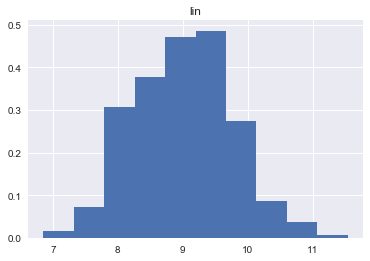

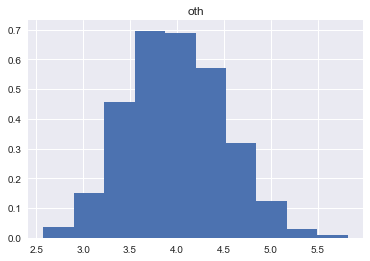

In [294]:
for key in res:
    plt.title(key)
    plt.hist(res[key].T[0]*100,normed=True)
    plt.show()

In [161]:

def update(Qs,pos,eta=.9,g=.1):
    Qs[pos-1] += eta * (int((pos+1)/len(Qs))+ g * Qs[pos]- Qs[pos-1])

In [162]:
Qs = np.zeros(4)

for trial in range(3):
    
    for x in range(1,4):
        update(Qs,x)
    [print('  {0:5.3f}  '.format(val),end='') for val in Qs];
    print()

  0.000    0.000    0.900    0.000  
  0.000    0.081    0.990    0.000  
  0.007    0.097    0.999    0.000  


In [163]:
g=.1
eta=.9
eta+eta**2*g

0.9810000000000001

In [164]:
3*eta-2*eta**2+eta**3

1.8090000000000002